In [1]:
import h5py
import numpy as np

# Original dataset path
file_path = r"C:\Users\rapur\Downloads\2018.01.OSC.0001_1024x2M.h5\2018.01\GOLD_XYZ_OSC.0001_1024.hdf5"

with h5py.File(file_path, 'r') as hf:
    Y = hf['Y'][:]  # (2555904, 24)
   
    # Count how many samples per class
    label_indices = np.argmax(Y, axis=1)
    unique, counts = np.unique(label_indices, return_counts=True)
   
    print("Modulation Index -> Count")
    for i, count in zip(unique, counts):
        print(f"{i:<2} -> {count}")


Modulation Index -> Count
0  -> 106496
1  -> 106496
2  -> 106496
3  -> 106496
4  -> 106496
5  -> 106496
6  -> 106496
7  -> 106496
8  -> 106496
9  -> 106496
10 -> 106496
11 -> 106496
12 -> 106496
13 -> 106496
14 -> 106496
15 -> 106496
16 -> 106496
17 -> 106496
18 -> 106496
19 -> 106496
20 -> 106496
21 -> 106496
22 -> 106496
23 -> 106496


In [2]:
modulation_labels = [
    '8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK',
    'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'OOK',
    'APSK16', 'APSK32', 'DQPSK', 'FSK8', 'MSK', 'OQPSK',
    'QAM128', 'QAM256', 'QAM32', 'QAM8', 'PSK2', 'PSK4'
]


In [3]:
import h5py

file_path = r"C:\Users\rapur\Downloads\radioml_5g_filtered.h5"

with h5py.File(file_path, 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]
    Z = hf['Z'][:]

    print("✅ Filtered dataset loaded!")
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)
    print("Z shape:", Z.shape)
    print("Number of 5G samples:", X.shape[0])


✅ Filtered dataset loaded!
X shape: (532480, 1024, 2)
Y shape: (532480, 24)
Z shape: (532480, 1)
Number of 5G samples: 532480


In [4]:
import h5py
import numpy as np

input_path = r"C:\Users\rapur\Downloads\radioml_5g_filtered.h5"
output_path = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"

# Number of total and per-class samples
total_samples = 100_000
num_classes = 5
samples_per_class = total_samples // num_classes

# 5G modulations you used earlier
five_g_indices = [0, 3, 7, 8, 9]  # 8PSK, BPSK, QAM16, QAM64, QPSK

with h5py.File(input_path, 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]
    Z = hf['Z'][:]

    labels = np.argmax(Y, axis=1)

    X_balanced = []
    Y_balanced = []
    Z_balanced = []

    for idx in five_g_indices:
        class_indices = np.where(labels == idx)[0]
        sampled_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        X_balanced.append(X[sampled_indices])
        Y_balanced.append(Y[sampled_indices])
        Z_balanced.append(Z[sampled_indices])

    X_balanced = np.concatenate(X_balanced, axis=0)
    Y_balanced = np.concatenate(Y_balanced, axis=0)
    Z_balanced = np.concatenate(Z_balanced, axis=0)

# Shuffle the dataset
shuffle_indices = np.random.permutation(total_samples)
X_balanced = X_balanced[shuffle_indices]
Y_balanced = Y_balanced[shuffle_indices]
Z_balanced = Z_balanced[shuffle_indices]

# Save to new HDF5 file
with h5py.File(output_path, 'w') as out_hf:
    out_hf.create_dataset('X', data=X_balanced)
    out_hf.create_dataset('Y', data=Y_balanced)
    out_hf.create_dataset('Z', data=Z_balanced)

print("✅ 100k balanced 5G RadioML subset saved successfully!")
print("Saved to:", output_path)
print("Shape:", X_balanced.shape, Y_balanced.shape, Z_balanced.shape)


✅ 100k balanced 5G RadioML subset saved successfully!
Saved to: C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5
Shape: (100000, 1024, 2) (100000, 24) (100000, 1)


In [5]:
import h5py
import numpy as np

# Load the balanced dataset
file_path = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"

with h5py.File(file_path, 'r') as hf:
    Y_balanced = np.array(hf['Y'])  # Shape: (100000, 24)
    
# Get the class labels (indices)
labels = np.argmax(Y_balanced, axis=1)

# Count samples per class
unique, counts = np.unique(labels, return_counts=True)

# Display the distribution
for modulation, count in zip(unique, counts):
    print(f"Class {modulation}: {count} samples")


Class 0: 20000 samples
Class 3: 20000 samples
Class 7: 20000 samples
Class 8: 20000 samples
Class 9: 20000 samples


In [6]:
import h5py
import numpy as np

# Load the balanced 100k dataset
file_path = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"

# Load the dataset
with h5py.File(file_path, 'r') as hf:
    X = np.array(hf['X'])  # shape: (100000, 1024, 2)
    Y = np.array(hf['Y'])  # shape: (100000, 24)
    Z = np.array(hf['Z'])  # shape: (100000, 1)

# 1. Check the shape of the raw input data X (before flattening)
print("Original X shape:", X.shape)

# 2. Flatten X data into a single vector per sample
X_flattened = X.reshape(X.shape[0], -1)  # Flatten the (100000, 1024, 2) to (100000, 2048)
print("Flattened X shape:", X_flattened.shape)

# 3. Convert Y labels into a binary classification (clean/noisy)
# Assuming Z contains the SNR, let's label based on the SNR:
# If SNR < threshold (e.g., 10), it's noisy (1), else it's clean (0)

threshold = 10  # This is an example, you can adjust it based on your data
Y_binary = np.where(Z < threshold, 1, 0)  # Create a binary label for noisy vs clean
print("Binary Y shape (clean/noisy):", Y_binary.shape)

# 4. Check the shape of the latent space (Z)
latent_dim = 100  # Example latent dimension
Z_sample = np.random.normal(0, 1, (1, latent_dim))  # Sample latent vector
print("Latent vector sample shape (Z):", Z_sample.shape)

# Now that the dimensions are checked, we can proceed with DCGAN setup


Original X shape: (100000, 1024, 2)
Flattened X shape: (100000, 2048)
Binary Y shape (clean/noisy): (100000, 1)
Latent vector sample shape (Z): (1, 100)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np

# === Load Data ===
file_path = r"C:\Users\rapur\Downloads\radioml_5g_balanced_100k.h5"
with h5py.File(file_path, 'r') as hf:
    X = np.array(hf['X'])  # (100000, 1024, 2)

# Reshape to (N, 2, 1024) for Conv1D processing
X_clean = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)  # (N, 2, 1024)
X_clean = (X_clean - X_clean.mean()) / X_clean.std()
X_clean = X_clean.clamp(-1, 1)

# Add synthetic Gaussian noise to create noisy inputs
noise_factor = 0.5
X_noisy = X_clean + noise_factor * torch.randn_like(X_clean)
X_noisy = X_noisy.clamp(-1, 1)

dataset = TensorDataset(X_noisy, X_clean)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# === Denoising Generator ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, 4, stride=2, padding=1),  # (B, 64, 512)
            nn.ReLU(True),
            nn.Conv1d(64, 128, 4, stride=2, padding=1),  # (B, 128, 256)
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1),  # (B, 64, 512)
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 2, 4, stride=2, padding=1),    # (B, 2, 1024)
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# === Discriminator ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv1d(32, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv1d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# === Training Setup ===
def train_denoising_gan(generator, discriminator, dataloader, epochs=20, device='cuda'):
    adversarial_loss = nn.BCELoss()
    l1_loss = nn.L1Loss()

    generator.to(device)
    discriminator.to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    lambda_l1 = 50  # Weight for L1 loss

    for epoch in range(epochs):
        for i, (noisy, clean) in enumerate(dataloader):
            noisy, clean = noisy.to(device), clean.to(device)
            batch_size = noisy.size(0)

            # === Train Discriminator ===
            fake = generator(noisy).detach()

            real_labels = torch.full((batch_size, 1), 0.9).to(device)
            fake_labels = torch.zeros((batch_size, 1)).to(device)

            real_preds = discriminator(clean)
            fake_preds = discriminator(fake)

            d_loss_real = adversarial_loss(real_preds, real_labels)
            d_loss_fake = adversarial_loss(fake_preds, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # === Train Generator ===
            generated = generator(noisy)
            g_preds = discriminator(generated)
            g_adv_loss = adversarial_loss(g_preds, real_labels)
            g_l1 = l1_loss(generated, clean)
            g_loss = g_adv_loss + lambda_l1 * g_l1

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Adv: {g_adv_loss.item():.4f} | G L1: {g_l1.item():.4f} | G Total: {g_loss.item():.4f}")


# === Run Training ===
generator = Generator()
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_denoising_gan(generator, discriminator, dataloader, epochs=20, device=device)

Epoch [1/20] | D Loss: 0.6876 | G Adv: 0.8385 | G L1: 0.2545 | G Total: 13.5619
Epoch [2/20] | D Loss: 0.6185 | G Adv: 0.8862 | G L1: 0.2199 | G Total: 11.8789
Epoch [3/20] | D Loss: 0.5191 | G Adv: 1.1952 | G L1: 0.2362 | G Total: 13.0063
Epoch [4/20] | D Loss: 0.6286 | G Adv: 1.4763 | G L1: 0.2306 | G Total: 13.0063
Epoch [5/20] | D Loss: 0.5441 | G Adv: 1.5854 | G L1: 0.2445 | G Total: 13.8088
Epoch [6/20] | D Loss: 0.4915 | G Adv: 1.3520 | G L1: 0.2096 | G Total: 11.8335
Epoch [7/20] | D Loss: 0.4095 | G Adv: 1.5134 | G L1: 0.2493 | G Total: 13.9804
Epoch [8/20] | D Loss: 0.4550 | G Adv: 1.8215 | G L1: 0.2123 | G Total: 12.4365
Epoch [9/20] | D Loss: 0.4289 | G Adv: 1.8955 | G L1: 0.2412 | G Total: 13.9578
Epoch [10/20] | D Loss: 0.6947 | G Adv: 1.5635 | G L1: 0.2591 | G Total: 14.5177
Epoch [11/20] | D Loss: 0.4545 | G Adv: 1.5494 | G L1: 0.2001 | G Total: 11.5546
Epoch [12/20] | D Loss: 0.4314 | G Adv: 1.8929 | G L1: 0.2185 | G Total: 12.8180
Epoch [13/20] | D Loss: 0.4454 | G Ad

D Loss: how well Discriminator is distinguishing real vs fake

G Adv(BCE): how well Generator is fooling the Discriminator

G L1(L1 loss): how close Generator output is to clean signal

G Total: overall Generator objective

g_loss = g_adv_loss + lambda_l1 * g_l1

Loss	Range to Aim For
D Loss	~0.4 to 0.7
G Adv	~0.6 to 1.5
G L1	~0.10 to 0.25
G Total	~6 to 13 (with λ = 50)

### G adv the loss between the Discriminator’s prediction and a label of 1.0 (i.e., real)

So it's high if the Discriminator thinks the generated signal is fake

It's low if the Discriminator is fooled


In [23]:
# === Save Models ===
torch.save(generator.state_dict(), "generator_denoising_5g.pth")
torch.save(discriminator.state_dict(), "discriminator_denoising_5g.pth")
print("✅ Models saved successfully!")


✅ Models saved successfully!


✅ Denoising GAN	Learns to map noisy → clean
✅ Conditional GAN (implicit)	Generator is conditioned on noisy signal

C:\Users\rapur\AppData\Local\Temp\ipykernel_37128\845684553.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_denoising_5g

🔊 SNR Before Denoising (I): 5.16 dB
✨ SNR After Denoising (I):  11.16 dB


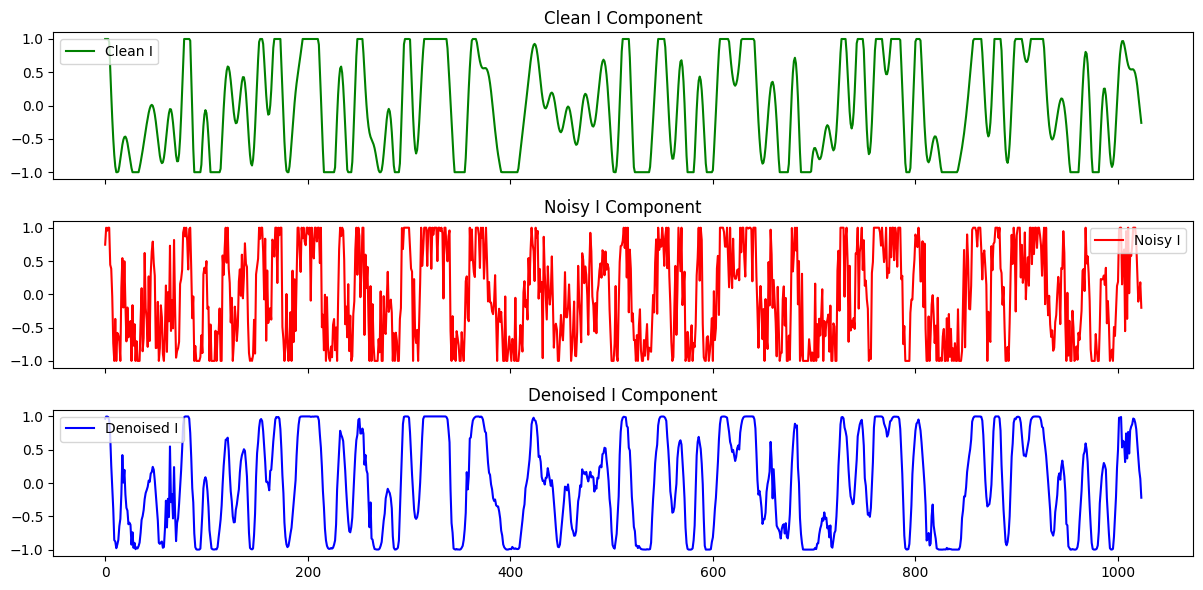

In [56]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# === Load from Full Dataset ===
file_path = r"C:\Users\rapur\Downloads\radioml_5g_filtered.h5"
idx = 532000  # Unused sample

with h5py.File(file_path, 'r') as hf:
    sample = hf['X'][idx]  # (1024, 2)

# === Prepare Signal ===
signal = torch.tensor(sample.T, dtype=torch.float32)  # (2, 1024)
signal = (signal - signal.mean()) / signal.std()
signal = signal.clamp(-1, 1)

# === Add Noise
noisy_signal = signal + 0.5 * torch.randn_like(signal)
noisy_signal = noisy_signal.clamp(-1, 1)

# === Load Generator ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator_denoising_5g.pth", map_location=device))
generator.eval()

# === Denoise ===
with torch.no_grad():
    denoised = generator(noisy_signal.unsqueeze(0).to(device)).cpu().squeeze(0)

# === SNR Function (I only)
def snr(signal, reference):
    noise = signal - reference
    return 10 * torch.log10(torch.mean(reference ** 2) / torch.mean(noise ** 2))

snr_before = snr(noisy_signal[0], signal[0]).item()
snr_after = snr(denoised[0], signal[0]).item()

print(f"🔊 SNR Before Denoising (I): {snr_before:.2f} dB")
print(f"✨ SNR After Denoising (I):  {snr_after:.2f} dB")

# === Plot in Separate Graphs ===
fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

axs[0].plot(signal[0], label='Clean I', color='green')
axs[0].set_title("Clean I Component")
axs[0].legend()

axs[1].plot(noisy_signal[0], label='Noisy I', color='red')
axs[1].set_title("Noisy I Component")
axs[1].legend()

axs[2].plot(denoised[0], label='Denoised I', color='blue')
axs[2].set_title("Denoised I Component")
axs[2].legend()

plt.tight_layout()
plt.show()


In [41]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# === Load Generator ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator_denoising_5g.pth", map_location=device))
generator.eval()

# === SNR Function ===
def snr(signal, reference):
    noise = signal - reference
    return 10 * torch.log10(torch.mean(reference ** 2) / torch.mean(noise ** 2))

# === Evaluate on Random Unused Samples ===
file_path = r"C:\Users\rapur\Downloads\radioml_5g_filtered.h5"
indices = random.sample(range(100000, 532480), 10)  # Samples not in training set

snrs_before = []
snrs_after = []

with h5py.File(file_path, 'r') as hf:
    for i, idx in enumerate(indices):
        sample = hf['X'][idx]  # (1024, 2)
        signal = torch.tensor(sample.T, dtype=torch.float32)
        signal = (signal - signal.mean()) / signal.std()
        signal = signal.clamp(-1, 1)

        noisy = signal + 0.5 * torch.randn_like(signal)
        noisy = noisy.clamp(-1, 1)

        with torch.no_grad():
            denoised = generator(noisy.unsqueeze(0).to(device)).cpu().squeeze(0)

        snr_b = snr(noisy, signal).item()
        snr_a = snr(denoised, signal).item()

        snrs_before.append(snr_b)
        snrs_after.append(snr_a)

        print(f"Sample {i+1} | SNR Before: {snr_b:.2f} dB | After: {snr_a:.2f} dB")

# === Final Summary ===
print("\n📈 Average SNR Before Denoising:", np.mean(snrs_before))
print("✨ Average SNR After Denoising: ", np.mean(snrs_after))
print("🚀 Average SNR Improvement:     ", np.mean(np.array(snrs_after) - np.array(snrs_before)))


Sample 1 | SNR Before: 5.21 dB | After: 11.62 dB
Sample 2 | SNR Before: 4.96 dB | After: 5.34 dB
Sample 3 | SNR Before: 5.00 dB | After: 11.21 dB
Sample 4 | SNR Before: 5.84 dB | After: 11.91 dB
Sample 5 | SNR Before: 5.61 dB | After: 10.96 dB
Sample 6 | SNR Before: 5.05 dB | After: 10.41 dB
Sample 7 | SNR Before: 4.66 dB | After: 4.43 dB
Sample 8 | SNR Before: 5.42 dB | After: 12.04 dB
Sample 9 | SNR Before: 5.55 dB | After: 12.20 dB
Sample 10 | SNR Before: 4.92 dB | After: 10.57 dB

📈 Average SNR Before Denoising: 5.221233177185058
✨ Average SNR After Denoising:  10.070663738250733
🚀 Average SNR Improvement:      4.849430561065674


C:\Users\rapur\AppData\Local\Temp\ipykernel_37128\966175926.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_denoising_5g

In [4]:
pip install streamlit

  Using cached streamlit-1.44.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached streamlit-1.44.1-py3-none-any.whl (9.8 MB)
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
Using cached cachetools-5.5.2-py3-none-any.

In [1]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv1d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 2, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [2]:
import torch
import numpy as np

def preprocess_input(np_data):
    x = torch.tensor(np_data.transpose(1, 0), dtype=torch.float32).unsqueeze(0)
    x = (x - x.mean()) / x.std()
    x = x.clamp(-1, 1)
    return x

def postprocess_output(tensor_output):
    return tensor_output.squeeze().detach().cpu().numpy().transpose(1, 0)


In [5]:
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import torch
from gan_model import Generator
from utils import preprocess_input, postprocess_output
import io

st.set_page_config(page_title="5G Signal Denoiser", layout="centered")
st.title("📡 5G Signal Denoiser using GAN")

# Upload
uploaded_file = st.file_uploader("Upload Noisy Signal (.npy format)", type=["npy"])
if uploaded_file:
    noisy_data = np.load(uploaded_file)  # shape: (1024, 2)
    
    st.subheader("📈 Noisy Signal")
    fig, ax = plt.subplots()
    ax.plot(noisy_data[:, 0], label="I")
    ax.plot(noisy_data[:, 1], label="Q")
    ax.legend()
    st.pyplot(fig)

    # Load Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator().to(device)
    model.load_state_dict(torch.load("generator_denoising_5g.pth", map_location=device))
    model.eval()

    # Process
    inp = preprocess_input(noisy_data).to(device)
    with torch.no_grad():
        denoised = model(inp)
    denoised_np = postprocess_output(denoised)

    st.subheader("🔧 Denoised Signal")
    fig2, ax2 = plt.subplots()
    ax2.plot(denoised_np[:, 0], label="I")
    ax2.plot(denoised_np[:, 1], label="Q")
    ax2.legend()
    st.pyplot(fig2)

    # Download result
    st.download_button("⬇️ Download Denoised Signal", data=denoised_np.tobytes(), file_name="denoised.npy")


ModuleNotFoundError: No module named 'gan_model'